In [11]:
from sklearn.linear_model import LinearRegression

#Regression model training and testing to compare outlier detection algorithm effects
def reg_train_test(X_train,y_train,X_test, y_test):
    # fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # evaluate the model
    ypred = model.predict(X_test)
    # evaluate predictions
    mae = mean_absolute_error(y_test, ypred)
    print('MAE: %.3f' % mae)

In [12]:
# Example based on https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
# evaluate model on the raw dataset
from pandas import read_csv
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = read_csv(url, header=None)
# retrieve the array
data = df.values
# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print("Shape of dataset: ",X_train.shape, y_train.shape)

reg_train_test(X_train,y_train,X_test, y_test)

Shape of dataset:  (339, 13) (339,)
MAE: 3.417


# Univariate outlier detection based on descriptive statistics 

In [13]:
#Univariate outlier detection based on descriptive statistics (three standard deviations)
#can be useful to identify extreme outliers
feature1=X_train[:,0]

three_std=feature1.std()*3
mean=feature1.mean()

inlier_low=mean-three_std
inlier_high=mean+three_std

print("mean: ",mean, "lower boundary inlier: ",inlier_low, "upper boundary inlier",inlier_high,"\n")

for value in feature1:
    if value < inlier_low or value > inlier_high:
        print(value," is a potential outlier")    

mean:  3.7939862536873155 lower boundary inlier:  -22.177520996105127 upper boundary inlier 29.765493503479757 

51.1358  is a potential outlier
73.5341  is a potential outlier
41.5292  is a potential outlier
45.7461  is a potential outlier
67.9208  is a potential outlier
38.3518  is a potential outlier


# Multivariate outlier detection based on distances

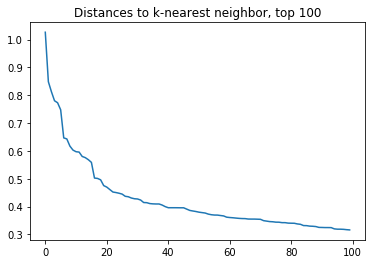

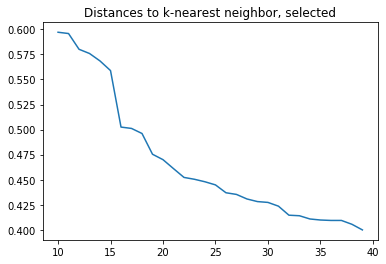

In [14]:
#Multivariate outlier detection based on distances
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

#normalize data to identify outliers
scaler = preprocessing.MinMaxScaler()
X= scaler.fit_transform(X_train)

#determine k nearest neighbors ()
k=3
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

#plot Distances to k-nearest neighbor, top 100
plt.title('Distances to k-nearest neighbor, top 100')
top_distance_min=0
top_distance_max=100
plt.plot(indices[top_distance_min:top_distance_max,0],-np.sort(-distances[:,k])[top_distance_min:top_distance_max])
plt.show()

#plot Distances to k-nearest neighbor, selected
plt.title('Distances to k-nearest neighbor, selected')
top_distance_min=10
top_distance_max=40
plt.plot(indices[top_distance_min:top_distance_max,0],-np.sort(-distances[:,k])[top_distance_min:top_distance_max])
plt.show()

In [15]:
#k= number of outliers // 10% of data
num_outliers= 20 # 35
outlier_indices=np.argpartition(distances[:,1],-num_outliers)[-num_outliers:]
inlier_indices=np.delete(indices[:,0], outlier_indices)

#print("Indices of outliers: ",outlier_indices)
#print("Indices of inliers: ",inlier_indices)
#print("Distances of outliers: ",distances[outlier_indices,1])
#print("Max 10 distances: ",-np.sort(-distances[:,1])[0:10])

# select all rows that are not outliers (inlier=1, outlier=-1)
X_train_red, y_train_red = X_train[inlier_indices, :], y_train[inlier_indices]

# Inliers vs. Outliers
print("Inliers: ",X_train_red.shape[0],"Outliers",X_train.shape[0]-X_train_red.shape[0])
print("Train regression model based on inliers and test it:")
reg_train_test(X_train_red,y_train_red,X_test, y_test)

Inliers:  319 Outliers 20
Train regression model based on inliers and test it:
MAE: 3.289


# Multivariate outlier detection based on density (clustering)

In [16]:
#Multivariate outlier detection based on density (clustering)
#Density Clustering
from sklearn.cluster import DBSCAN
import pandas as pd

clustering = DBSCAN(eps=0.42, min_samples=5).fit(X)

inliers=[]
outliers=[]
index_upper=distances[:,1].size

for index in range (0,index_upper):
    if clustering.labels_[index] == -1:
        outliers.append([index, distances[index,1]])
    else:
        inliers.append([index, distances[index,1]])

inliers_df=pd.DataFrame(inliers,columns=['index','distance'])
outliers_df=pd.DataFrame(outliers,columns=['index','distance'])

print("inliers: ",inliers_df.describe())
print("\noutliers: ",outliers_df.describe())

inliers:              index    distance
count  321.000000  321.000000
mean   168.579439    0.167936
std     98.669401    0.083947
min      0.000000    0.031569
25%     84.000000    0.113670
50%    167.000000    0.151446
75%    254.000000    0.208289
max    338.000000    0.416416

outliers:              index   distance
count   18.000000  18.000000
mean   176.500000   0.421312
std     87.451667   0.154454
min     34.000000   0.201963
25%     94.000000   0.282542
50%    187.500000   0.442709
75%    250.250000   0.467356
max    313.000000   0.757561


In [17]:
# select all rows that are not outliers (inlier=1, outlier=-1)
X_train_red, y_train_red = X_train[inliers_df['index'], :], y_train[inliers_df['index']]

# Inliers vs. Outliers
print("Inliers: ",X_train_red.shape[0],"Outliers",X_train.shape[0]-X_train_red.shape[0])
print("Train regression model based on inliers and test it:")
reg_train_test(X_train_red,y_train_red,X_test, y_test)

Inliers:  321 Outliers 18
Train regression model based on inliers and test it:
MAE: 3.272


Outlier Detection based on Local Outlier Factor

The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection. Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers.

# Multivariate outlier detection using local outlier factor (LOF)

In [18]:
#Multivariate outlier detection using local outlier factor (LOF)
from sklearn.neighbors import LocalOutlierFactor

# re-use the same dataset like before url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
# identify outliers in the training dataset
lof = LocalOutlierFactor(n_neighbors=20)
y_out = lof.fit_predict(X)
# select all rows that are not outliers
mask = y_out != -1
X_train_red, y_train_red = X_train[mask, :], y_train[mask]

# Inliers vs. Outliers
print("Inliers: ",X_train_red.shape[0],"Outliers",X_train.shape[0]-X_train_red.shape[0])
print("Train regression model based on inliers and test it:")
reg_train_test(X_train_red,y_train_red,X_test, y_test)

Inliers:  327 Outliers 12
Train regression model based on inliers and test it:
MAE: 3.336
